In [29]:
import pandas as pd
import pandas as pd
import copy
import random as rd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt 
import math
from matplotlib import font_manager

fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

In [11]:
class Geothermal:
	# global self.data1,self.data2,self.grdHt,self.grdPos,self.grdTmprt

	def __init__(self, aWell, hf, gt ):
		self.data1 = aWell.values
		self.data2 = [hf, gt]


		sz = len( self.data1 )
		self.grdHt = [hf ]
		for i in range(sz-1):
			thicki = self.data1[i,4]
			Ai = self.data1[i,3]
			self.grdHt.append( self.grdHt[-1]- thicki*Ai )


		# In[52]:


		self.grdTmprt = [gt]
		for i in range(sz-1):
			grdHti= self.grdHt[i]
			thicki= self.data1[i,4]
			Ki = self.data1[i,2]
			Ai = self.data1[i,3]
			self.grdTmprt.append( self.grdTmprt[-1] +  grdHti*thicki/Ki - Ai*thicki*thicki/(2*Ki) )
			


		# In[54]:


		self.grdPos = [0]
		for i in range(sz-1):
			thicki= self.data1[i,4]
			self.grdPos.append( self.grdPos[-1] + thicki )


	def caldepPos(self, dep ):
	    idx = -1
	    if dep>=self.grdPos[-1]:
	        idx = len( self.grdPos )-1
	    else:
	        for i in range( len(self.grdPos )-1):
	            if dep>=self.grdPos[i] and dep<self.grdPos[i+1]:
	                idx = i 
	                break
	    return idx


	# In[69]:


	def caltmprt(self, dep ):
		pos = self.caldepPos( dep )
		thicki = dep - self.grdPos[pos]

		grdHti= self.grdHt[pos]
		Ki = self.data1[pos,2]
		Ai = self.data1[pos,3]

		# print(self.grdTmprt[pos], grdHti, thicki, Ai, Ki)
		ht = self.grdTmprt[pos] +  grdHti*thicki/Ki - Ai*thicki*thicki/(2*Ki)

		return ht 

In [12]:
# 读取地层热物性参数，随机生成一组参数
# 地层热物性参数 
# D:\workplace\geoproject\pictureproject\data\material\温度\地层热物性参数.xlsx
pthparam= r'D:\workplace\geoproject\pictureproject\data\material\温度\地层热物性参数.xlsx'

dataparam= pd.read_excel(pthparam)



def crtSubPop(dataparam, i):
    row = dataparam.iloc[i]

    Ki = -1*row['热导率偏值'] + row['热导率偏值']*2*rd.random() + row['热导率基值']
    Ai = -1*row['生热率偏值'] + row['生热率偏值']*2*rd.random() + row['生热率基值']  

    return [Ki,Ai]

def crtPop(dataparam):
    lstparam=[]
    for index, row in dataparam.iterrows():
        Ki = -1*row['热导率偏值'] + row['热导率偏值']*2*rd.random() + row['热导率基值']
        Ai = -1*row['生热率偏值'] + row['生热率偏值']*2*rd.random() + row['生热率基值']

        lstparam.append([Ki,Ai])
    return lstparam
    
def getLstKA(lstparam):
    lstK=[]
    lstA=[]
    for i in lstparam:
        lstK.append(i[0])
        lstA.append(i[1])
    return lstK,lstA

In [13]:
# 获得地层层序-井深和厚度
# 获得基本信息
pthLayerSeq = r'D:\workplace\geoproject\pictureproject\data\material\温度\地层层序-井深.xlsx'
dataLayerSeq= pd.read_excel(pthLayerSeq)
pthBaseInfo = r'D:\workplace\geoproject\pictureproject\data\material\温度\基本信息.xlsx'
dataBaseInfo= pd.read_excel(pthBaseInfo)

allTmprt = {}
for index, row in dataBaseInfo.iterrows():
    posWell = row['井位']
    hf = row['地表热流']
    gt = row['地表温度']

    pthStaticTmprt = r'D:\workplace\geoproject\pictureproject\data\material\温度\xlsx-静温\静温-%s.xlsx' % posWell
    staticTmprt = pd.read_excel( pthStaticTmprt )

    allTmprt[posWell] = staticTmprt 

In [17]:


def gettar(lstparam, aX):
    lstK,lstA = getLstKA(lstparam)
    tar = 0 
    for index, row in dataBaseInfo.iterrows():
        posWell = row['井位']
        if posWell not in aX:
            continue

        hf = row['地表热流']
        gt = row['地表温度']

        aWell = dataLayerSeq[['地层',posWell]]
        aWell['K'] = lstK
        aWell['A'] = lstA

        aWell.dropna(inplace=True) 
        aWell= aWell.reset_index(drop=True)

        thick=[]
        h = float( dataBaseInfo[ dataBaseInfo['井位']==posWell ]['补心高']  )
        dpth = aWell.iloc[0][posWell]
        thick.append( (dpth - h)/1000 )


        for index1, row1 in aWell.iterrows():
            if index1 == 0:
                continue
            # print(row['轮探1井'],  aWell.iloc[index-1]['轮探1井'], row['轮探1井']- aWell.iloc[index-1]['轮探1井'] )
            thicki= row1[posWell]- aWell.iloc[index1-1][posWell]
            thick.append( thicki/1000 )
        aWell['Thick'] = thick

        geo = Geothermal(aWell, hf, gt )

        staticTmprt = allTmprt[posWell]
        for index1, row1 in staticTmprt.iterrows():
            dpth = row1['井深']/1000
            realtmprt = row1['温度']
            guesstmprt = geo.caltmprt(dpth)

            # print(posWell, dpth, realtmprt, guesstmprt)

            tar += abs(guesstmprt-realtmprt)

    return tar
# lstparam = crtPop(dataparam)
# gettar( lstparam )

In [23]:
#编码，数值编码
#初始化种群
# 交叉
# 变异
# 选择

def cross(npop1, npop2 ):
    pop1 = copy.deepcopy( npop1)
    pop2 = copy.deepcopy( npop2)

    sz= len(pop1)

    pos = rd.randint(0, sz-1-1)
    
    tmp=pop1[0:pos+1]
    pop1[0:pos+1] = pop2[0:pos+1]
    pop2[0:pos+1] = tmp 
    return [pop1,pop2]

def mutate(npop1, prob):
    pop1= copy.deepcopy( npop1 )

    sz = len( pop1)
    # pos = rd.randint(0, sz-1)

    for i in range(sz):
        if rd.random()< prob:
            subpop = crtSubPop(dataparam, i)
            pop1[i] = subpop

    return pop1 

def gettarlst( newpop, trainX ):
    lst = []
    for i in newpop:
        lst.append( gettar(i, trainX) )
    return lst

popsz = 40
numiter= 150
probMutate = 0.1

X = []
trainX = []
validX = []
for index, row in dataBaseInfo.iterrows():
    posWell = row['井位']
    X.append( posWell )
trainX.extend( X[0:len(X)-1])
validX.append( X[-1])


error = []
pop = []
for i in range(popsz):
    pop.append( crtPop(dataparam) )
for iter in range(numiter):
    newpop=[]
    newpop.extend( pop )

    newpop.extend( cross(pop[0], pop[-1]))
    for i in range(popsz-1):
        newpop.extend( cross(pop[i], pop[i+1]) )
    
    for i in  pop:
        newpop.append( mutate( i, probMutate ))
    
    tar = gettarlst( newpop, trainX )
    # print(tar)
    idx = sorted(range(len(tar)), key=lambda k: tar[k])
    # print(idx)
    pop = [newpop[i] for i in idx[0:popsz] ]

    print(gettar(pop[0], trainX) )
    error.append( gettar(pop[0], trainX) )
    



865.5807805716396
835.7310311316237
835.7310311316237
800.4402732932747
789.0148263173401
775.5078237307793
775.5078237307793
770.4191021293444
770.4191021293444
760.8190563412991
759.3192292143812
757.0831380065711
754.3127293114445
750.9458537015717
750.9458537015717
748.3309795620448
747.415003264035
747.3484277574064
747.3484277574064
738.4698674340332
738.4698674340332
735.8699907182056
735.8699907182056
735.6196178252981
735.4250230307639
733.0355338622319
726.3539937386388
723.2069896350406
723.2069896350406
720.7300530578841
718.1840626715652
717.931132976561
717.931132976561
717.931132976561
715.2103207374178
715.2103207374178
715.2103207374178
714.9573910424135
714.9573910424135
714.9573910424135
714.9573910424135
714.9573910424135
714.9573910424135
714.9573910424135
714.9573910424135
714.9573910424135
714.9573910424135
714.0995394495916
713.7916440683679
713.7916440683679
713.7916440683679
713.7916440683679
713.4833972044502
713.4833972044502
713.4833972044502
713.4833972044

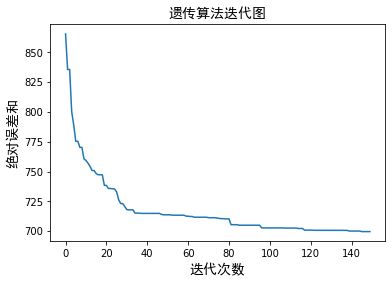

In [32]:
plt.plot([i for i in range(len(error))], error)
plt.title('遗传算法迭代图', FontProperties=fontP)
plt.xlabel('迭代次数', FontProperties=fontP)
plt.ylabel('绝对误差和', FontProperties=fontP)
plt.show()

In [33]:
gettar(pop[0], validX) 

94.45771677265219

In [35]:
dataparam

,地层,热导率基值,热导率偏值,生热率基值,生热率偏值,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,第四系,1.759,0.831,1.724,0.656,NaN,NaN,NaN
1,新近系,1.759,0.831,1.724,0.656,NaN,NaN,NaN
2,古近系,1.898,0.624,1.230,0.477,NaN,NaN,NaN
3,白垩系,1.587,0.805,1.380,0.662,NaN,NaN,NaN
4,侏罗系,1.736,0.334,2.064,0.999,NaN,NaN,NaN
5,三叠系,2.025,0.389,1.344,0.420,NaN,NaN,NaN
6,二叠系,2.135,0.592,1.479,1.051,NaN,NaN,NaN
7,石炭系,2.211,0.542,1.282,0.897,NaN,NaN,NaN
8,泥盆系,2.496,0.671,1.469,1.161,NaN,NaN,NaN
9,志留系,2.457,0.575,1.432,0.723,NaN,NaN,NaN


In [44]:
for i in range( len(dataparam['地层']) ):
    print( dataparam['地层'][i], '&', round(pop[0][i][0],3), '&', round(pop[0][i][1],3), '\\\\')
    print('\cmidrule(l  r ){1-3}')

第四系 & 2.579 & 2.238 \\
\cmidrule(l  r ){1-3}
新近系 & 1.74 & 2.067 \\
\cmidrule(l  r ){1-3}
古近系 & 2.495 & 1.548 \\
\cmidrule(l  r ){1-3}
白垩系 & 1.059 & 1.02 \\
\cmidrule(l  r ){1-3}
侏罗系 & 2.055 & 2.04 \\
\cmidrule(l  r ){1-3}
三叠系 & 1.939 & 1.285 \\
\cmidrule(l  r ){1-3}
二叠系 & 2.72 & 0.76 \\
\cmidrule(l  r ){1-3}
石炭系 & 1.719 & 0.416 \\
\cmidrule(l  r ){1-3}
泥盆系 & 3.151 & 2.455 \\
\cmidrule(l  r ){1-3}
志留系 & 3.018 & 0.803 \\
\cmidrule(l  r ){1-3}
奥陶系 & 2.139 & 1.006 \\
\cmidrule(l  r ){1-3}
寒武系 & 3.203 & 0.39 \\
\cmidrule(l  r ){1-3}
震旦系 & 4.246 & 0.401 \\
\cmidrule(l  r ){1-3}
